In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [1]:
from tqdm.auto import tqdm
from typing import List
import re
from typing import List, Tuple, Dict
from data.dataset import GraphDataset, ReimburseGraphDataset, DataAugmentationLevel, DialogNode, NodeType
import seaborn as sns
import pandas

/mount/arbeitsdaten/asr-2/vaethdk/virtualenvs/cts_en/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
DEVICE = 'cuda:0'
import torch
# a= torch.zeros(1,1,device=DEVICE)

In [2]:
human_data_train = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/rain_answers.json', False, augmentation=DataAugmentationLevel.NONE)
human_data_test = ReimburseGraphDataset('en/reimburse/test_graph.json', 'en/reimburse/test_answers.json', False, augmentation=DataAugmentationLevel.NONE)
generated_data_train_v1 = ReimburseGraphDataset('en/reimburse/rain_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v1.json")
generated_data_train_v2 = ReimburseGraphDataset('en/reimburse/train_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v2.json")
generated_data_train_v3 = ReimburseGraphDataset('en/reimburse/rain_graph.json', 'en/reimburse/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY, augmentation_path="en/reimburse/generated/train_questions_v3.json")

- not using synonyms
===== Dataset Statistics =====
- files:  resources/en/train_graph.json resources/en/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 279
- loaded original data: True
- loaded generated data: False
- not using synonyms
===== Dataset Statistics =====
- files:  resources/en/test_graph.json resources/en/test_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 173
- loaded original data: True
- loaded generated data: False
- Loading questions from  resources/en/generated/train_questions_v1.json
- not using synonyms
===== Dataset Statistics =====
- files:  resources/en/train_graph.json resources/en/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 800
- loaded original data: False
- loaded generated data: True
- Loading questions from  resources/en/generated/train_questions_v2.json
- not using synonyms
===== Dataset Statistics =====
- files:  resources/en/trai

# CALCULATING PERPLEXITY

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
model_name_or_path = "TheBloke/upstage-llama-30b-instruct-2048-GPTQ"
model_basename = "gptq_model-4bit--1g"

use_triton = False

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,
                                          use_fast=True,
                                          cache_dir="/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/",)


/mount/arbeitsdaten/asr-2/vaethdk/virtualenvs/cts_en/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = AutoGPTQForCausalLM.from_quantized("/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/TheBloke--upstage-llama-30b-instruct-2048-GPTQ",
        # model_basename=model_basename,
        # revision="gptq-4bit-32g-actorder_True",
        use_safetensors=True,
        trust_remote_code=False,
        device="cuda:0",
        use_triton=use_triton,
        quantize_config=None)

CUDA extension not installed.
The safetensors archive passed at /mount/arbeitsdaten/asr-2/vaethdk/resources/weights/TheBloke--upstage-llama-30b-instruct-2048-GPTQ/gptq_model-4bit-32g.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.
skip module injection for FusedLlamaMLPForQuantizedModel not support integrate without triton yet.


In [7]:
def generate_prompt(system: str, user: str, question) -> Tuple[str, Tuple[int, int]]:
    """ Returns:
        Generated prompt,
        List of start/end index of each question within the tokenized prompt,
    """
    incremental_prompt = f"""
### System:
{system}

### User:
{user}

### Assistant:
"""
    question_start_idx = tokenizer(incremental_prompt, return_tensors='pt').input_ids.size(-1) - 1
    incremental_prompt += question
    question_end_idx = tokenizer(incremental_prompt, return_tensors='pt').input_ids.size(-1)
    incremental_prompt += "\n"
    return incremental_prompt, (question_start_idx, question_end_idx)


In [8]:
system = """You are a helpful assistant creating a list of FAQ-style questions from given facts.
Only generate questions that can be answered by the given facts, without any external knowledge.
Remove some information, especially nouns and named entities, between generated questions.
Use casual language.
Order the generated paraphrases in a numbered list."""

def user(answer_text: str) -> str:
    return f'Generate a FAQ-style question from the fact: "{answer_text}"'

In [10]:
def calculate_ppl(node: DialogNode) -> List[float]:
    """ 
    Returns 
        A list of token probabilities (one tensor per question)
        A list of token indices
    """
    # generate prompt
    ppls = []
    with torch.no_grad():
        for question in node.questions:
            prompt, (question_start_idx, question_end_idx) = generate_prompt(system=system, user=user(answer_text=node.text), question=question.text)
            # forward prompt
            inputs = tokenizer(prompt, return_tensors='pt').input_ids.to(DEVICE)
            output = model(input_ids=inputs, labels=inputs)
            ppl = torch.exp(output.loss.squeeze()[question_start_idx:question_end_idx])
            ppls.append(ppl.item())
    return ppls


In [3]:
def load_ppl(ppl_file: str) -> List[float]:
    # Calculate perplexity of human data 
    ppls = torch.load(ppl_file, map_location=lambda storage, loc: storage)
    perplexities = []
    for node_key in ppls:
        node_data = ppls[node_key] # list with probabilities per question
        perplexities.extend(node_data)
    print(ppl_file, ":", len(perplexities), "samples")
    return perplexities

### HUMAN QUESTION PERPLEXITY

In [13]:
data = {}
for node in tqdm(human_data_train.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "human_question_probs.pt")

100%|██████████| 80/80 [06:41<00:00,  5.02s/it]


In [14]:
data = {}
for node in tqdm(human_data_test.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "human_question_probs_testdata.pt")

100%|██████████| 80/80 [04:09<00:00,  3.12s/it]


In [15]:
data = {}
for node in tqdm(generated_data_train_v1.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v1.pt")

100%|██████████| 80/80 [19:56<00:00, 14.95s/it]


In [16]:
data = {}
for node in tqdm(generated_data_train_v2.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v2.pt")

100%|██████████| 80/80 [19:55<00:00, 14.94s/it]


In [17]:
data = {}
for node in tqdm(generated_data_train_v3.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        node_question_ppls = calculate_ppl(node)
        data[node.key] = node_question_ppls
torch.save(data, "generated_question_probs_v3.pt")

100%|██████████| 80/80 [10:25<00:00,  7.82s/it]


In [35]:
df = pandas.DataFrame(
    [{"source": "human_questions_train", "ppl": ppl} for ppl in load_ppl('human_question_probs.pt')] + 
    [{"source": "human_questions_test", "ppl": ppl} for ppl in load_ppl('human_question_probs_testdata.pt')] +
    [{"source": 'generated v1', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v1.pt')] +
    [{"source": 'generated v2', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v2.pt')] +
    [{"source": 'generated v3', "ppl": ppl} for ppl in load_ppl('generated_question_probs_v3.pt')]
)

generation/human_question_probs.pt : 269 samples
generation/human_question_probs_testdata.pt : 167 samples
generation/generated_question_probs_v1.pt : 800 samples
generation/generated_question_probs_v2.pt : 800 samples
generation/generated_question_probs_v3.pt : 416 samples


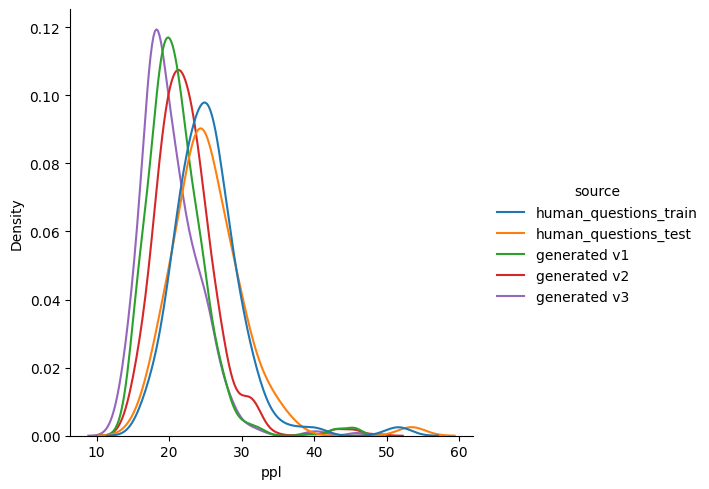

In [37]:
sns.displot(df.reset_index(drop=True), x="ppl", kind="kde", hue='source', common_norm=False)

## Question Lengths

In [16]:
def calculate_question_length(data: GraphDataset):
    question_length = []
    for node in tqdm(data.nodes_by_type[NodeType.INFO]):
        for question in node.questions:
            question_length.append(len(question.text.split(" ")))
    return question_length

In [17]:
question_length_human_train = calculate_question_length(human_data_train)
question_length_human_test = calculate_question_length(human_data_test)
question_length_generated_v1 = calculate_question_length(generated_data_train_v1)
question_length_generated_v2 = calculate_question_length(generated_data_train_v2)
question_length_generated_v3 = calculate_question_length(generated_data_train_v3)

100%|██████████| 80/80 [00:00<00:00, 115984.90it/s]


In [18]:
df = pandas.DataFrame(
    [{"source": "human_questions_train", "#words": length} for length in question_length_human_train] + 
    [{"source": "human_questions_test", "#words": length} for length in question_length_human_test] +
    [{"source": 'generated v1', "#words": length} for length in question_length_generated_v1] + 
    [{"source": 'generated v2', "#words": length} for length in question_length_generated_v2] +
    [{"source": 'generated v3', "#words": length} for length in question_length_generated_v3] 
)

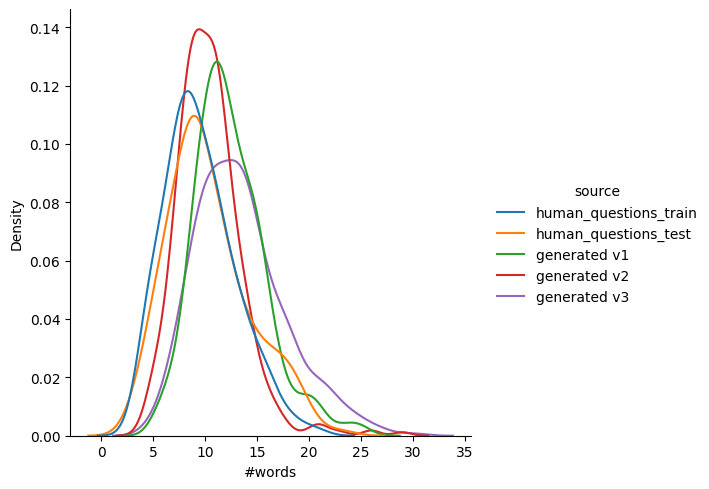

In [19]:
sns.displot(df.reset_index(drop=True), x="#words", kind="kde", hue='source', common_norm=False)

## Question Similarities

Two scenarios:

1. Pair-wise question similarity between all questions of a node (WITHIN the same dataset)
2. Pair-wise question similarity between the questions of a node from one dataset and the questions from another dataset

In [24]:
from data.dataset import Question
from sentence_transformers import SentenceTransformer, util

similarity_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=DEVICE, cache_folder = '/mount/arbeitsdaten/asr-2/vaethdk/resources/weights').to(DEVICE)

In [25]:
def calculate_similarity(questions_1: List[Question], questions_2: List[Question]):
    #Compute embedding for both lists
    embeddings1 = similarity_model.encode([q.text for q in questions_1], convert_to_tensor=True)
    embeddings2 = similarity_model.encode([q.text for q in questions_2], convert_to_tensor=True)

    #Compute pair-wise cosine-similarities -> #questions_1 x #questions_2
    cosine_scores = util.cos_sim(embeddings1, embeddings2)
    return cosine_scores.to("cpu")


#### 1. scenario: Pair-wise question similarity between all questions of a node (WITHIN the same dataset)

In [26]:
def within_dataset_similarity(dataset: GraphDataset) -> List[float]:
    similarities = []
    for node in tqdm(dataset.nodes_by_type[NodeType.INFO]):
        if len(node.questions) > 0:
            pariwise_sim = calculate_similarity(node.questions, node.questions)
            # ignore self-similarity (matrix diagnoal)
            # also: matrix is symmetric
            # --> only look at triangle above diagonal
            pariwise_sim = torch.triu(pariwise_sim, diagonal=1) # will set elements on and below diagonal to 0
            pariwise_sim = pariwise_sim.view(-1) # convert to list
            relevant_elements = pariwise_sim[pariwise_sim.nonzero()].view(-1) # extract nonzero entries
            similarities.extend(relevant_elements.tolist())     
    return similarities           

In [27]:
human_train_similarity = within_dataset_similarity(human_data_train)
human_test_similarity = within_dataset_similarity(human_data_test)
generated_similarity_v1 = within_dataset_similarity(generated_data_train_v1)
generated_similarity_v2 = within_dataset_similarity(generated_data_train_v2)
generated_similarity_v3 = within_dataset_similarity(generated_data_train_v3)

100%|██████████| 80/80 [00:03<00:00, 21.24it/s]


In [28]:
df = pandas.DataFrame(
    [{"source": "human_questions_train", "similarity": sim} for sim in human_train_similarity] + 
    [{"source": "human_questions_test", "similarity": sim} for sim in human_test_similarity] +
    [{"source": 'generated v1', "similarity": sim} for sim in generated_similarity_v1] + 
    [{"source": 'generated v2', "similarity": sim} for sim in generated_similarity_v2] +
    [{"source": 'generated v3', "similarity": sim} for sim in generated_similarity_v3]
)

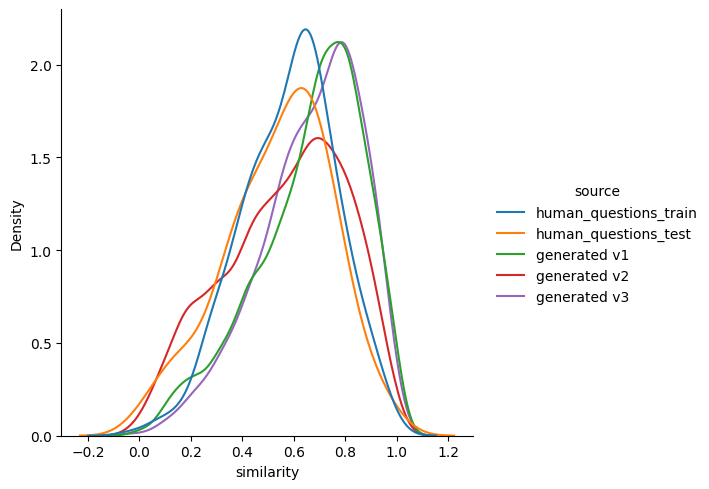

In [29]:
sns.displot(df.reset_index(drop=True), x="similarity", kind="kde", hue='source', common_norm=False)

#### 2. scenario: Pair-wise question similarity between the questions of a node from one dataset and the questions from another dataset

In [30]:
def between_dataset_similarity(dataset_1: GraphDataset, dataset_2: GraphDataset) -> List[float]:
    similarities = []
    for node_1 in tqdm(dataset_1.nodes_by_type[NodeType.INFO]):
        node_2 = dataset_2.nodes_by_key[node_1.key]
        if len(node_1.questions) > 0 and len(node_2.questions) > 0:
            pariwise_sim = calculate_similarity(node_1.questions, node_2.questions)
            pariwise_sim = pariwise_sim.view(-1) # convert to list
            similarities.extend(pariwise_sim.tolist())     
    return similarities           

In [31]:
sim_human_train_vs_human_test = between_dataset_similarity(human_data_train, human_data_test)

sim_human_train_vs_generated_v1 = between_dataset_similarity(human_data_train, generated_data_train_v1)
sim_human_train_vs_generated_v2 = between_dataset_similarity(human_data_train, generated_data_train_v2)
sim_human_train_vs_generated_v3 = between_dataset_similarity(human_data_train, generated_data_train_v3)

sim_human_test_vs_generated_v1 = between_dataset_similarity(human_data_test, generated_data_train_v1)
sim_human_test_vs_generated_v2 = between_dataset_similarity(human_data_test, generated_data_train_v2)
sim_human_test_vs_generated_v3 = between_dataset_similarity(human_data_test, generated_data_train_v3)

100%|██████████| 80/80 [00:02<00:00, 27.80it/s]


In [32]:
df = pandas.DataFrame(
    [{"source": "human(train) vs human(test)", "similarity": sim} for sim in sim_human_train_vs_human_test] + 
    [{"source": "human(train) vs generated v1", "similarity": sim} for sim in sim_human_train_vs_generated_v1] +
    [{"source": "human(train) vs generated v2", "similarity": sim} for sim in sim_human_train_vs_generated_v2] +
    [{"source": "human(train) vs generated v3", "similarity": sim} for sim in sim_human_train_vs_generated_v3] +
    [{"source": 'human(test) vs generated v1', "similarity": sim} for sim in sim_human_test_vs_generated_v1] + 
    [{"source": 'human(test) vs generated v2', "similarity": sim} for sim in sim_human_test_vs_generated_v2] + 
    [{"source": 'human(test) vs generated v3', "similarity": sim} for sim in sim_human_test_vs_generated_v3] 
)

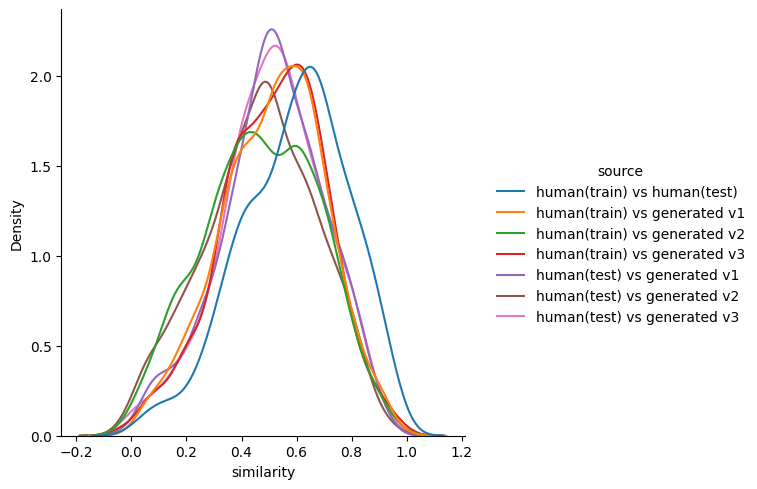

In [33]:
sns.displot(df.reset_index(drop=True), x="similarity", kind="kde", hue='source', common_norm=False)

100%|██████████| 80/80 [00:03<00:00, 23.33it/s]


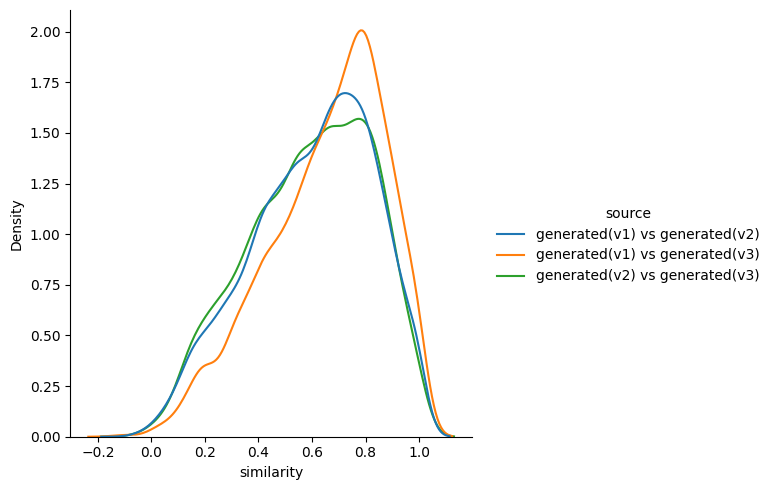

In [38]:
sim_generated_v1_vs_generated_v2 = between_dataset_similarity(generated_data_train_v1, generated_data_train_v2)
sim_generated_v1_vs_generated_v3 = between_dataset_similarity(generated_data_train_v1, generated_data_train_v3)
sim_generated_v2_vs_generated_v3 = between_dataset_similarity(generated_data_train_v2, generated_data_train_v3)

df = pandas.DataFrame(
    [{"source": 'generated(v1) vs generated(v2)', "similarity": sim} for sim in sim_generated_v1_vs_generated_v2] + 
    [{"source": 'generated(v1) vs generated(v3)', "similarity": sim} for sim in sim_generated_v1_vs_generated_v3] +
    [{"source": 'generated(v2) vs generated(v3)', "similarity": sim} for sim in sim_generated_v2_vs_generated_v3]
)

sns.displot(df.reset_index(drop=True), x="similarity", kind="kde", hue='source', common_norm=False)

# Conclusions

1. Generate shorter questions
2. Generate more diverse questions 